## CLAHE

CLAHE(Contrast Limiting Adaptive Histogram Equalization)는  
영상 전체에 이퀄라이즈를 적용했을때 너무 밝은 부분이 날아가는 현상을 막기 위해 영상을 일정한 영역으로 나눠서 이퀄라이즈를 적용하는 것을 말한다.  
노이즈가 증폭되는 것을 막기 위해 어느 히스토그램 계급(bin)이든 지정된 제한 값을 넘으면 그 픽셀은 다른 계급으로 배분하고 나서 이퀄라이즈를 적용한다.

##### clahe = cv2.createCLAHE(clipLimit, tileGridSize) : CLAHE 생성
* clipLimit : Contrast 제한 경계 값, 기본 40.0
* tileGridSize : 영역 크기, 기본 8x8
* clahe : 생성된 CLAHE 객체

##### clahe.apply(src) : CLAHE 적용
* src : 입력 영상

In [1]:
import cv2
import numpy as np
import matplotlib.pylab as plt

# 이미지를 읽어서 YUV 컬러 스페이스로 변경
img = cv2.imread('./img/bright.jpg')
img_yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)

# 밝기 채널에 대해서 이퀄라이즈 적용
img_eq = img_yuv.copy()
img_eq[:,:,0] = cv2.equalizeHist(img_eq[:,:,0])
ing_eq = cv2.cvtColor(img_eq, cv2.COLOR_YUV2BGR)

# 밝기채널에 대해 CLAHE 적용
img_clahe = img_yuv.copy()
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
img_clahe[:,:,0] = clahe.apply(img_clahe[:,:,0])
img_clahe = cv2.cvtColor(img_clahe, cv2.COLOR_YUV2BGR)

cv2.imshow('Before', img)
cv2.imshow('CLAHE', img_clahe)
cv2.imshow('equalizeHist', img_eq)
cv2.waitKey()
cv2.destroyAllWindows()

### 2D 히스토그램

1차원 히스토그램은 각 픽셀이 몇개인지 세어서 그래프로 표현하는데,  
2차원 히스토그램은 이와 같은 축이 2개이고 각각의 축이 만나는 지점의 개수를 표현한다.  

다음은 화창한 가을 하늘의 산을 찍은 사진을 2차원 히스토그램으로 표현한 것이다.

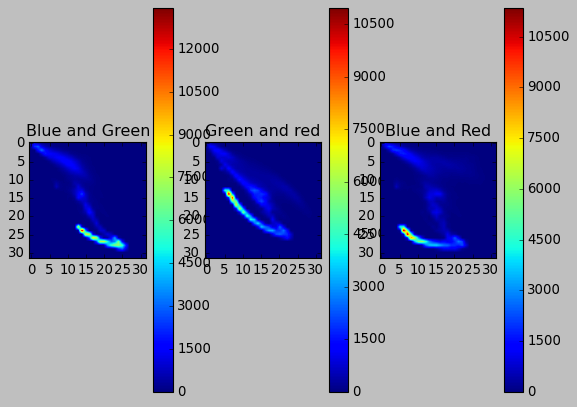

In [2]:
import cv2
import matplotlib.pylab as plt

plt.style.use('classic')
img = cv2.imread('./img/mountain.jpg')

plt.subplot(131)
hist = cv2.calcHist([img], [0,1], None, [32,32], [0,256,0,256]) # 파랑과초록에 대한 히스토그램
p = plt.imshow(hist)
plt.title('Blue and Green')
plt.colorbar(p)

plt.subplot(132)
hist = cv2.calcHist([img], [1,2], None, [32,32], [0,256,0,256]) # 초록과 빨강에 대한 히스토그램
p = plt.imshow(hist)
plt.title('Green and red')
plt.colorbar(p)

plt.subplot(133)
hist = cv2.calcHist([img], [0,2], None, [32,32], [0,256,0,256]) # 파랑과 빨강에 대한 히스토그램
p = plt.imshow(hist)
plt.title('Blue and Red')
plt.colorbar(p)

plt.show()

### 역투영

2차원 히스토그램과 HSV 컬러 스페이스를 이용하면 색상으로 특정 물체나 사물의 일부분을 배경에서 분리할 수 있다.  
기본 원리는 물체가 있는 관심영역의 H 와 V 값의 분포를 얻어낸 후 전체 영상에서 해당 분포의 픽셀만 찾아내는 것이다.

아래 예제는 마우스로 선택한 특정 물체만 배경에서 분리할 수 있다.  

##### cv2.calcBlackProject(img, channel, hist, ranges, scale)
* img : 입력 영상, [img]처럼 리스트로 감싸서 표현
* channel : 처리할 채널, 리스트로 감싸서 표현
  * 1채널 : [0], 2채널 : [0,1], 3채널 : [0,1,2]
* hist : 역투영에 사용할 히스토그램
* ranges : 각 픽셀이 가질 수 있는 값의 범위
* scale : 결과에 적용할 배율 계수

* 마우스로 선택한 영역의 물체 배경 제거

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

win_name = 'black_projection'
img = cv2.imread('./img/pump_horse.jpg')
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
draw = img.copy()

# 역투영된 결과를 마스킹해서 결과를 출력하는 공통합수
def masking(bp, win_name):
    disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    cv2.filter2D(bp,-1,disc,bp)
    _, mask = cv2.threshold(bp, 1, 255, cv2.THRESH_BINARY)
    result = cv2.bitwise_and(img, img, mask=mask)
    cv2.imshow(win_name, result)

# 직접 구현한 역투영 함수
def backProject_manual(hist_roi):
    # 전체 영상에 대한 H, S 히스토그램 계산
    hist_img = cv2.calcHist([hsv_img], [0,1], None, [180,256], [0,180,0,256])
    # 선택 영역과 전체 영상에 대한 히스토그램 비율 계산
    hist_rate = hist_roi/ (hist_img+1)
    # 비율에 맞는 픽셀값 매핑
    h,s,v = cv2.split(hsv_img)
    bp = hist_rate[h.ravel(), s.ravel()]
    bp = np.minimum(bp, 1)
    bp = bp.reshape(hsv_img.shape[:2])
    cv2.normalize(bp,bp,0,255,cv2.NORM_MINMAX)
    bp = bp.astype(np.uint8)
    # 역투영 결과로 마스킹해서 결과 출력
    masking(bp, 'result_manual')
    
# opencv API로 구현한 함수
def backProject_cv(hist_roi):
    # 역투영 함수 호출
    bp = cv2.calcBackProject([hsv_img], [0,1], hist_roi, [0,180,0,256], 1)
    # 역투영 결과로 마스킹해서 결과 출력
    masking(bp, 'result_cv')
    
# ROI선택    
(x,y,w,h) = cv2.selectROI(win_name, img, False)
if w>0 and h>0:
    roi = draw[y:y+h, x:x+w]
    cv2.rectangle(draw, (x,y), (x+w, y+h), (0,0,255), 2)
    # 선택한 ROI를 HSV컬러 스페이스로 변경
    hsv_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2HSV)
    # H, S채널에 대한 히스토그램 계산
    hist_roi = cv2.calcHist([hsv_roi], [0,1], None, [180,256], [0, 180, 0, 256])
    # ROI의 히스토그램을 매뉴얼 구현함수와 opencv를 이용하는 ㅎ마수에 각각 전달
    backProject_manual(hist_roi)
    backProject_cv(hist_roi)

cv2.imshow(win_name, draw)
cv2.waitKey()
cv2.destroyAllWindows()

### 히스토그램 비교

히스토그램은 영상의 픽셀값의 분포를 갖는 정보이다. 그러므로 이것을 비교하면 영상에 사용한 픽셀의 색상 비중이 얼마나 비슷한지 알 수 있다.  

##### cv2.compareHist(hist1, hist2, method)
* hist1, hist2 : 비교할 2개의 히스토그램, 크기와 차원이 같아야한다
* method : 비교 알고리즘 선택 플래그 상수
  * cv2.HISTCMP_CORREL : 상관관계(1: 완전일치, -1: 최대 불일치, 0: 무관계)
  * cv2.HISTCMP_CHISQR : 카이제곱(0: 완전일치, 큰값(미정): 최대 불일치)
  * cv2.HISTCMP_INTERSECT : 교차(1: 완전일치, 0: 최대 불일치(1로 정규화한 경우))
  * cv2.HISTCMP_BHATTACHARYYA : 바타차야(0: 완전일치, 1: 최대 불일치)
  * cv2.HISTCMP_HELLINGER : HISTCMP_BHATTACHARYYA와 동일  
  
서로 다른 영상의 히스토그램을 같은 조건으로 비교하기 위해서는 먼저 히스토그램을 노멀라이즈 해야한다.  
이미지가 크면 픽셀수가 많고, 히스토그램의 값도 커지기 때문이다.

CORREL    	img1:   1.00		img2:   0.70		img3:   0.56		img4:   0.23	
CHISQR    	img1:   0.00		img2:  67.33		img3:  35.71		img4:1129.49	
INTERSECT 	img1:   1.00		img2:   0.54		img3:   0.40		img4:   0.18	
BHATTACHARYYA	img1:   0.00		img2:   0.48		img3:   0.47		img4:   0.79	


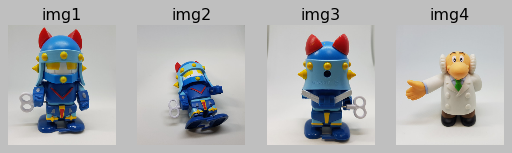

In [4]:
import cv2
import numpy as np
import matplotlib.pylab as plt

img1 = cv2.imread('./img/taekwonv1.jpg')
img2 = cv2.imread('./img/taekwonv2.jpg')
img3 = cv2.imread('./img/taekwonv3.jpg')
img4 = cv2.imread('./img/dr_ochanomizu.jpg')

cv2.imshow('query', img1)
imgs = [img1, img2, img3, img4]
hists = []

for i, img in enumerate(imgs):
    plt.subplot(1, len(imgs), i+1)
    plt.title('img%d'% (i+1))
    plt.axis('off')
    plt.imshow(img[:,:,::-1])
    # 이미지를 HSV로 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    # H,S 채널에 대한 히스토그램 계산
    hist = cv2.calcHist([hsv], [0,1], None, [180,256], [0,180,0,256])
    # 0~1로 정규화
    cv2.normalize(hist,hist,0,1,cv2.NORM_MINMAX)
    hists.append(hist)
    
query = hists[0]
methods = {'CORREL' : cv2.HISTCMP_CORREL, 'CHISQR' : cv2.HISTCMP_CHISQR,
          'INTERSECT' : cv2.HISTCMP_INTERSECT,
          'BHATTACHARYYA' : cv2.HISTCMP_BHATTACHARYYA}

for j, (name, flag) in enumerate(methods.items()):
    print('%-10s'%name, end='')
    for i, (hist, img) in enumerate(zip(hists, imgs)):
        # img1 과 각 이미지의 히스토그램 비교
        ret = cv2.compareHist(query, hist, flag)
        if flag == cv2.HISTCMP_INTERSECT:  # 교차분석인 경우
            ret = ret/np.sum(query)        # 비교대상으로 나누어 1로 정규화
        print("\timg%d:%7.2f"%(i+1, ret), end='\t')
    print()

plt.show()

## 실전 응용

### 해골과 반 합성

In [5]:
import cv2
import numpy as np

# 영상의 15%를 알파 블렌딩의 범위로 지정
alpha_width_rate = 15

# 합성할 두 영상 읽기
img_face = cv2.imread('./img/man_face.jpg')
img_skull = cv2.imread('./img/skull.jpg')

# 입력 영상과 같은 크기의 결과 영상 준비
img_comp = np.zeros_like(img_face)

# 연산에 필요한 좌표 계산
height, width = img_face.shape[:2]
middle = width//2
alpha_width = width * alpha_width_rate // 100
start = middle - alpha_width//2
step = 100/alpha_width
# 입력 영상의 절반씩 복사해서 결과 영상에 합성
img_comp[:, :middle, : ] = img_face[:, :middle, :].copy()
img_comp[:, middle:, : ] = img_skull[:, middle:, :].copy()
cv2.imshow('half', img_comp)

# 알파 값을 바꾸면서 알파 블렌딩 적용
for i in range(alpha_width+1 ):
    alpha = (100 - step * i) / 100 # 증감 간격에 따른 알파 값(1~0)
    beta = 1 - alpha               # 베타값(0~1)
    # 알파 블렌딩 적용
    img_comp[:, start+i] = img_face[:, start + i] * alpha + img_skull[:, start+i] * beta
    print(i, alpha, beta)
    
cv2.imshow('half skull', img_comp)
cv2.waitKey()
cv2.destroyAllWindows()

0 1.0 0.0
1 0.9895833333333333 0.01041666666666674
2 0.9791666666666667 0.02083333333333326
3 0.96875 0.03125
4 0.9583333333333333 0.04166666666666674
5 0.9479166666666667 0.05208333333333326
6 0.9375 0.0625
7 0.9270833333333333 0.07291666666666674
8 0.9166666666666667 0.08333333333333326
9 0.90625 0.09375
10 0.8958333333333333 0.10416666666666674
11 0.8854166666666667 0.11458333333333326
12 0.875 0.125
13 0.8645833333333333 0.13541666666666674
14 0.8541666666666667 0.14583333333333326
15 0.84375 0.15625
16 0.8333333333333333 0.16666666666666674
17 0.8229166666666665 0.17708333333333348
18 0.8125 0.1875
19 0.8020833333333333 0.19791666666666674
20 0.7916666666666665 0.20833333333333348
21 0.78125 0.21875
22 0.7708333333333333 0.22916666666666674
23 0.7604166666666665 0.23958333333333348
24 0.75 0.25
25 0.7395833333333333 0.26041666666666674
26 0.7291666666666665 0.2708333333333335
27 0.71875 0.28125
28 0.7083333333333333 0.29166666666666674
29 0.6979166666666665 0.3020833333333335
30 0

### 모션 감지

In [6]:
import cv2
import numpy as np

# 감도 설정(카메라 품질에 따라 조정 필요)
thresh = 25   # 달라진 픽셀값 기준치 설정
max_diff = 5  # 달라진 픽셀 개 기준치 설정

# 카메라 캡션 장치 준비
a, b, c = None, None, None
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 480)   # 프레임 폭을 480으로 설정
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 320)  # 프레임 높이를 320으로 설정

if cap.isOpened():
    ret, a = cap.read()   # a프레임 읽기
    ret, b = cap.read()   # b프레임 읽기
    
    while ret:
        ret, c = cap.read()   # c프레임 읽기
        draw = c.copy()       # 출력 영상에 사용할 복제본
        if not ret:
            break
        # 3개의 영상을 그레이 스케일로 변경    
        a_gray = cv2.cvtColor(a, cv2.COLOR_BGR2GRAY)
        b_gray = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
        c_gray = cv2.cvtColor(c, cv2.COLOR_BGR2GRAY)
        # a-b, b-a 절대값 차 구하기 
        diff1 = cv2.absdiff(a_gray, b_gray)
        diff2 = cv2.absdiff(b_gray, c_gray)
        # 스레시홀드로 기준치 이내의 차이는 무시
        ret, diff1_t = cv2.threshold(diff1, thresh, 255, cv2.THRESH_BINARY)
        ret, diff2_t = cv2.threshold(diff2, thresh, 255, cv2.THRESH_BINARY)
        # 두 차이에 대해서 AND연산, 두 영상의 차이가 모두 발견된 경우
        diff = cv2.bitwise_and(diff1_t, diff2_t)
        
        # 열림 연산으로 노이즈 제거
        k = cv2.getStructuringElement(cv2.MORPH_CROSS, (3,3))
        diff = cv2.morphologyEx(diff, cv2.MORPH_OPEN, k)
        # 차이가 발생한 픽셀이 개수 판단 후 사각형 그리기
        diff_cnt = cv2.countNonZero(diff)
        if diff_cnt > max_diff:
            nzero = np.nonzero(diff)  # 0이 아닌 픽셀의 좌표 얻기
            cv2. rectangle(draw, (min(nzero[1]), min(nzero[0])),
                           (max(nzero[1]), max(nzero[0])), (0,255,0),2)
            
            cv2.putText(draw, "Motion Detected", (10, 30),
                        cv2.FONT_HERSHEY_DUPLEX, 0.5, (0,0,255))
        # 컬러 스케일 영상과 스레시 홀드 영상을 통합해서 출력    
        stacked = np.hstack((draw, cv2.cvtColor(diff, cv2.COLOR_GRAY2BGR)))
        cv2.imshow('motion sensor', stacked)
        # 다음 비교를 위해 영상 순서 정리    
        a = b
        b = c
            
        if cv2.waitKey(1) & 0xFF ==27:
            break